In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

# Descargar Dataset

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download 'landlord/handwriting-recognition'

100% 1.26G/1.26G [00:37<00:00, 42.7MB/s]
100% 1.26G/1.26G [00:37<00:00, 35.8MB/s]


In [ ]:
! unzip handwriting-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_

In [ ]:
! rm handwriting-recognition.zip
! rm kaggle.json

# Modelo

## Load and view data

In [ ]:
train = pd.read_csv('written_name_train_v2.csv')
valid = pd.read_csv('written_name_validation_v2.csv')

In [ ]:
# plt.figure(figsize=(15, 10))

# for i in range(6):
#     ax = plt.subplot(2, 3, i+1)
#     img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
#     image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#     plt.imshow(image, cmap = 'gray')
#     plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
#     plt.axis('off')

# plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Cleaning Data

In [ ]:
# # Validar NaN values
# print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
# print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

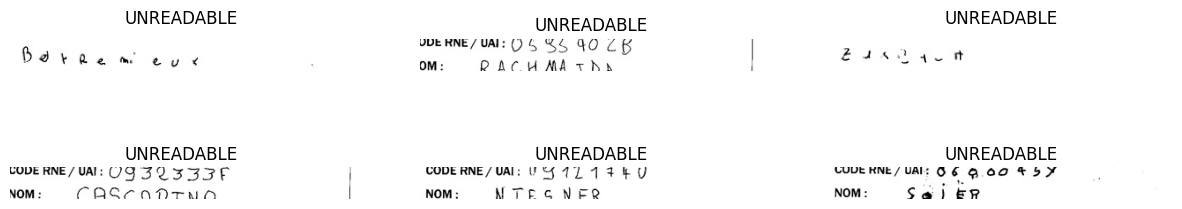

In [ ]:
# Eliminando imagenes ilegibles

unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [ ]:
# Validar si hay algun Identity en minuscula
# train_test = train.copy()
# train_test['column1'] =train_test['IDENTITY'].str.islower().all()
# train_test[train_test['column1'] == True]

In [ ]:
#Convertir todos los Identity a mayuscula
train.loc[:,'IDENTITY'] = train.loc[:,'IDENTITY'].str.upper()
valid.loc[:,'IDENTITY'] = valid.loc[:,'IDENTITY'].str.upper()

# Reiniciar los indicess
train.reset_index(inplace = True, drop=True)
valid.reset_index(inplace = True, drop=True)

## Preprocessing and preparing the images for training

* Se cargan las imagenes a escala de grises con ancho 256 y alto 64.  
* El ancho y alto son cortados si la el tamano de la imagen es mayor a 256X64 , en caso contrario la imagen es rellenada con pixeles en blanco hasta llegar a este tamano
* Finalmente la imagen se rota en sentido de las manesillas del reloj para que el texto no quede horizontal si no alineado con el eje vertical.
* Se normaliza la imagen al rango [0,1]

In [ ]:
def preprocess(img):
    (h, w) = img.shape

    final_img = np.ones([64, 256])*255 # Espacios en blanco

    # crop
    if w > 256:
        img = img[:, :256]

    if h > 64:
        img = img[:64, :]


    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size = 25000
valid_size= 3000

In [ ]:
# img_dir = 'train_v2/train/'+train.loc[1, 'FILENAME']
# image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
# image = preprocess(image)
# print(image[103])
# image = image/255. # Normalizacion [0,1]
# print(image[103])

# train_x.append(image)

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = 'train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255. # Normalizacion [0,1]
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = 'validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255. # Normalizacion [0,1]
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))

    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
# name = 'JEBASTIN'
# print(name, '\n',label_to_num(name))

* train_y contiene los valores reales convertido a un arreglo de numeros , el tamano de cada label es igual a max_str_len
* train_label_len contiene el tamano del valor real de cada label ( sin relleno )   
* train_input_len Contiene el tamano de la prediccion de cada label , el tamano de todas las predicciones es constante
* train_output es un  output para  ctc loss.

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])

In [ ]:
# print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100],
#       '\ntrain_input_len : ', train_input_len[100])

# Model

## Building the model

In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 256, 64, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

La dimension de salida de la prediccion es (64,30) . El modelo predice palabras de 64 caracteres y cada caracter contiene la probabilidad de 30 letras que definimos anteriormente .

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

## Entrenamiento

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                    optimizer=Adam(lr = 0.0001),
                    metrics=['accuracy'])

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=10)

## Model performance para el set de validacion


In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1],
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

157/157 [==============================] - 3s 16ms/step


In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 77.85%
Correct words predicted      : 46.62%


## Algunas predicciones en el set de pruebas

1/1 [==============================] - 0s 23ms/step


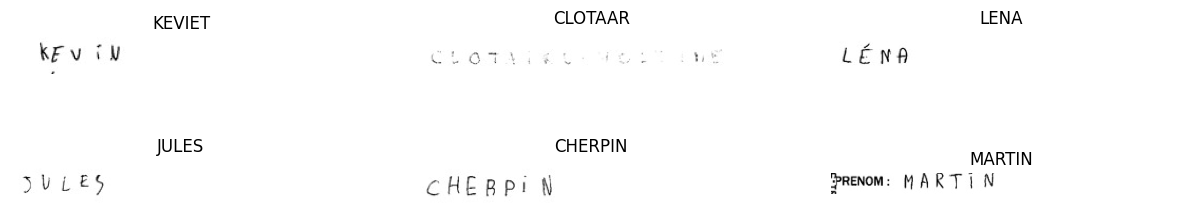

In [ ]:
test = pd.read_csv('written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')

    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

1/1 [==============================] - 0s 71ms/step


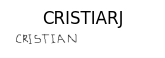

In [ ]:
ax = plt.subplot(2, 3, i+1)
img_dir = 'test7.jpg'
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1],
                                    greedy=True)[0][0])
plt.title(num_to_label(decoded[0]), fontsize=12)
plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
model.save('../api/Model/model_new.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
